# 프로젝트 : 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용해보기

1. 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
2. 학습된 모델로 sp_tokenize() 메소드 구현하기
3. 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
4. KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
5. SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

# 평가조건
1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?
    - 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?
    - SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
3. SentencePiece의 성능을 다각도로 비교분석하였는가?
    - SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

# 1. 모듈 임포트

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sentencepiece as spm
import urllib.request
from tqdm import tqdm
import pandas as pd
import os
import re
from konlpy.tag import Mecab, Okt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

tf.random.set_seed(1234)
np.random.seed(1234)

# 2. 데이터 불러오기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f4620555d90>)

In [3]:
path_to_file = os.getenv('HOME')+'/aiffel/going deeper'

train_data = pd.read_table(path_to_file + '/ratings_train.txt')
test_data = pd.read_table(path_to_file + '/ratings_test.txt')

In [4]:
display(train_data.head())
display(test_data.head())

print('train_data 길이:{}'.format(len(train_data)))
print('test_data 길이:{}'.format(len(test_data)))

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


train_data 길이:150000
test_data 길이:50000


In [5]:
train_data1 = train_data[['document','label']]
test_data1 = test_data[['document','label']]

display(train_data1.head())
display(test_data1.head())

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


,document,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# 3. 데이터 전처리하기
중복, 결측치, 텍스트에 대한 전처리 등을 수행하였습니다.

## 3-1. 중복 제거

In [6]:
train_data1.drop_duplicates(subset=['document'], inplace = True)
test_data1.drop_duplicates(subset=['document'], inplace = True)
print('train 데이터 수:',len(train_data1))
print('test 데이터 수:',len(test_data1))

train 데이터 수: 146183
test 데이터 수: 49158


## 3-2. 결측치 제거

In [7]:
train = train_data1.dropna(how = 'any') # Null 값이 존재하는 행 제거
test = test_data1.dropna(how = 'any') # Null 값이 존재하는 행 제거
print('train 데이터 수:',len(train))
print('test 데이터 수:',len(test))

train 데이터 수: 146182
test 데이터 수: 49157


## 3-3. 데이터 셔플링

In [8]:
data = pd.concat([train, test], axis=0)

In [9]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

shuffled_data = data.iloc[indices]

In [10]:
train1, test1 = shuffled_data[:len(train)], shuffled_data[len(train):]

train1.reset_index(inplace=True, drop=True)
test1.reset_index(inplace=True, drop=True)

print('train 데이터 수:', len(train1))
print('test 데이터 수:', len(test1))

train 데이터 수: 146182
test 데이터 수: 49157


## 3-4. 텍스트 전처리
- 한글, 영어, 숫자, 구둣점을 제외한 나머지는 제거해주는 전처리를 진행하였습니다.

In [11]:
# 텍스트 전처리
def preprocess_text(data):
    new_sentence = []
    
    for sentence in data['document']:
        # 한글, 영어, 숫자, 구둣점을 제외한 모든 문자 제거
        text = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\s\.,!?]', '', sentence)
        new_sentence.append(text)
        
    return new_sentence

In [12]:
train1['document'] = preprocess_text(train1)
test1['document'] = preprocess_text(test1)

## 3-5. 데이터 길이 확인
- 문장의 길이를 확인하기 위한 함수를 구현하였습니다.

In [13]:
def data_len(data):

    min_len = 999
    max_len = 0
    sum_len = 0

    print("Data Size:", len(data))

    for sen in data['document']:
        length = len(sen)
        if min_len > length: min_len = length
        if max_len < length: max_len = length
        sum_len += length

    print("문장의 최단 길이:", min_len)
    print("문장의 최장 길이:", max_len)
    print("문장의 평균 길이:", sum_len // len(data))

    sentence_length = np.zeros((max_len), dtype=int)

    for sen in data['document']:
        sentence_length[len(sen)-1] += 1

    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title("Sentence Length Distribution")
    plt.show()

Data Size: 146182
문장의 최단 길이: 0
문장의 최장 길이: 140
문장의 평균 길이: 35


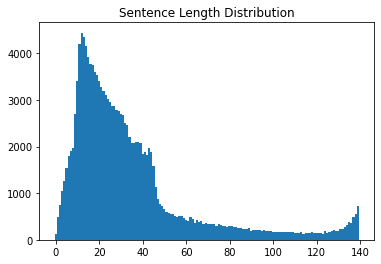

In [14]:
data_len(train1)

Data Size: 49157
문장의 최단 길이: 0
문장의 최장 길이: 140
문장의 평균 길이: 35


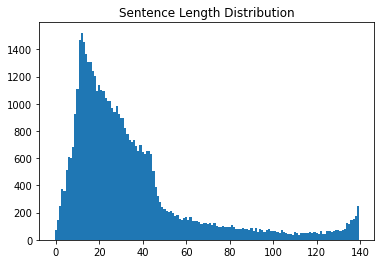

In [15]:
data_len(test1)

전처리된 텍스트의 길이를 확인하였는데, train과 test 모두 동일하게 나왔습니다.

In [16]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [17]:
below_threshold_len(80, train1['document'])

전체 샘플 중 길이가 80 이하인 샘플의 비율: 90.9879465324048


In [18]:
below_threshold_len(80, test1['document'])

전체 샘플 중 길이가 80 이하인 샘플의 비율: 90.91685822975364


train, test 모두 길이를 80 기준으로 전체 샘플에서 약 91%를 차지하는 것을 알 수 있습니다.

길이가 80 이상인 데이터들은 없애는 작업을 진행하겠습니다.

In [20]:
train11 = train1[train1['document'].apply(lambda x : len(x) <= 80)]
test11 = test1[test1['document'].apply(lambda x : len(x) <= 80)]

print('전처리 전 train 데이터 수:', len(train1))
print('전처리 전 test 데이터 수:', len(test1))
print('-------'*5)
print('전처리 후 train 데이터 수:', len(train11))
print('전처리 후test 데이터 수:', len(test11))

전처리 전 train 데이터 수: 146182
전처리 전 test 데이터 수: 49157
-----------------------------------
전처리 후 train 데이터 수: 133008
전처리 후test 데이터 수: 44692


# 4. SentencePiece 모델 학습
인터넷 서칭을 통해 필요한 파라미터들을 추가로 넣어주었습니다.

하지만 BPE 타입으로 실행하였을때 시간이 상당히 오래 걸려 모델과 vocab 생성을 진행하지 못하였습니다.

따라서 unigram 모델로 vocab_size(15000,30000)를 다르게 한 2가지 모델을 생성하였습니다.

In [21]:
temp_file = os.getenv('HOME') + '/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'
vocab_size = 30000
max_len = 999999
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3
train_large_corpus = True

with open(temp_file, 'w') as f:
    for row in train11['document']:
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} \
    --model_prefix=sentence_uni15 \
    --max_sentence_length={} \
    --vocab_size={} \
    --pad_id={} \
    --bos_id={} \
    --eos_id={} \
    --unk_id={} \
    --train_extremely_large_corpus={}'.format(temp_file, max_len, vocab_size-15000+4, pad_id, bos_id, eos_id, unk_id, train_large_corpus)
)

spm.SentencePieceTrainer.Train(
    '--input={} \
    --model_prefix=sentence_uni30 \
    --max_sentence_length={} \
    --vocab_size={} \
    --pad_id={} \
    --bos_id={} \
    --eos_id={} \
    --unk_id={} \
    --train_extremely_large_corpus={}'.format(temp_file, max_len, vocab_size+4, pad_id, bos_id, eos_id, unk_id, train_large_corpus)
)

# spm.SentencePieceTrainer.Train(
#     '--input={} \
#     --model_prefix=sentence_bpe15 \
#     --model_type=bpe \
#     --max_sentence_length={} \
#     --vocab_size={} \
#     --pad_id={} \
#     --bos_id={} \
#     --eos_id={} \
#     --unk_id={} \
#     --train_extremely_large_corpus={}'.format(temp_file, max_len, vocab_size-10000+4, pad_id, bos_id, eos_id, unk_id, train_large_corpus)
# )

# spm.SentencePieceTrainer.Train(
#     '--input={} \
#     --model_prefix=sentence_bpe25 \
#     --model_type=bpe \
#     --max_sentence_length={} \
#     --vocab_size={} \
#     --pad_id={} \
#     --bos_id={} \
#     --eos_id={} \
#     --unk_id={} \
#     --train_extremely_large_corpus={}'.format(temp_file, max_len, vocab_size+4, pad_id, bos_id, eos_id, unk_id, train_large_corpus)
# )

!ls -l sentence_uni15*
!ls -l sentence_uni30*
# !ls -l sentence_bpe15*
# !ls -l sentence_bpe25*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp     --model_prefix=sentence_uni15     --max_sentence_length=999999     --vocab_size=15004     --pad_id=0     --bos_id=1     --eos_id=2     --unk_id=3     --train_extremely_large_corpus=True
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: sentence_uni15
  model_type: UNIGRAM
  vocab_size: 15004
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  r

-rw-r--r-- 1 root root 517274 May 24 12:16 sentence_uni15.model
-rw-r--r-- 1 root root 292959 May 24 12:16 sentence_uni15.vocab
-rw-r--r-- 1 root root 828566 May 24 12:16 sentence_uni30.model
-rw-r--r-- 1 root root 618008 May 24 12:16 sentence_uni30.vocab


sentencepiece 모델이 잘 만들어졌는지를 확인할 수 있는 함수를 작성하였습니다.

In [22]:
def sentencepiece_check(model, text):
    s = spm.SentencePieceProcessor()
    s.Load(model)
    print(model)
    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds(text)
    print(tokensIDs)
    
    # SentencePiece를 활용한 sentence -> encoded pieces
    print(s.SampleEncodeAsPieces(text,1, 0.0))
    
    # SentencePiece를 활용한 encoding -> sentence 복원
    print(s.DecodeIds(tokensIDs))
    print('\n')

In [23]:
sentencepiece_check('sentence_uni15.model', '내이름은이승현이야')
sentencepiece_check('sentence_uni30.model', '내이름은이승현이야')

sentence_uni15.model
[77, 3563, 20, 9, 824, 678, 672]
['▁내', '이름', '은', '이', '승', '현', '이야']
내이름은이승현이야


sentence_uni30.model
[68, 2937, 20, 11, 1821, 985, 642]
['▁내', '이름', '은', '이', '승', '현', '이야']
내이름은이승현이야




두가지 모델 모두 잘 만들어진것을 확인할 수 있습니다.

# 5. Tokenizer 만들기
- 위에서 만들어진 sentencepiece 모델을 바탕으로 토크나이저를 만들어주는 함수를 구현하겠습니다.
- 리뷰의 길이가 80이상인 데이터는 제외하고, vocab, 패딩 등을 해주었습니다.

In [24]:
def sp_tokenize(model_name, vocab, train, test):
    
    s = spm.SentencePieceProcessor()
    s.Load(model_name)
    
    train_list = []
    test_list = []

    for sen in train['document']:
        train_list.append(s.EncodeAsIds(sen))
        
    for sen in test['document']:
        test_list.append(s.EncodeAsIds(sen))

    with open("./{}".format(vocab), 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    train_tensor = tf.keras.preprocessing.sequence.pad_sequences(train_list, maxlen=80, padding='pre')
    test_tensor = tf.keras.preprocessing.sequence.pad_sequences(test_list, maxlen=80, padding='pre')
    
    train_label = np.array(train['label'])
    test_label = np.array(test['label'])

    return train_tensor, train_label, test_tensor, test_label, word_index, index_word

In [25]:
train15, train_label15, test15, test_label15, uni15_word_index, uni15_index_word = sp_tokenize('sentence_uni15.model', 'sentence_uni15.vocab',train11, test11)
train30, train_label30, test30, test_label30, uni30_word_index, uni30_index_word = sp_tokenize('sentence_uni30.model', 'sentence_uni30.vocab',train11, test11)

# 6. 데이터 split
- 학습을 위하여 validation 데이터를 만들어주도록 하겠습니다.

In [27]:
from sklearn.model_selection import train_test_split

x_train15, x_val15, y_train15, y_val15 = train_test_split(train15,
                                                  train_label15,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  stratify=train_label15,
                                                  random_state=1234)

x_train30, x_val30, y_train30, y_val30 = train_test_split(train30,
                                                  train_label30,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  stratify=train_label30,
                                                  random_state=1234)

print(x_train15.shape)
print(y_train15.shape)
print(x_val15.shape)
print(y_val15.shape)

(106406, 80)
(106406,)
(26602, 80)
(26602,)


# 7. 모델 구성하기
- 지난 exploration_08 당시 성능이 가장 좋았던 BiLSTM을 활용하여 보겠습니다.

In [30]:
vocab_size = len(uni15_word_index)  # 어휘 사전의 크기입니다
word_vector_dim = 64  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 
batch_size = 256
dropout_rate = 0.2

In [31]:
class BiLSTModel(tf.keras.Model):
    def __init__(self, vocab_size, word_vector_dim, dropout_rate):
        super(BiLSTModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, word_vector_dim)
        self.bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense1 = tf.keras.layers.Dense(8, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x = self.bilstm(x)
        x = self.dropout(x, training=training)
        x = self.dense1(x)
        outputs = self.dense2(x)
        
        return outputs

# 모델 생성
bilstm_model = BiLSTModel(vocab_size, word_vector_dim, dropout_rate)

# 8. 모델 훈련 및 평가

## 8-1. vocab 15000개 모델 훈련 및 평가

In [36]:
# 모델 빌드
bilstm_model.build(input_shape=(None, 80)) #input_text의 길이를 넣음
                   
# 모델 컴파일
bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
                   
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
                   
epochs=10

bilstm_model15_history = bilstm_model.fit(x_train15,
                                        y_train15,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        validation_data=(x_val15, y_val15),
                                        verbose=1,
                                        callbacks=[es])

Epoch 1/10
416/416 [==============================] - 13s 20ms/step - loss: 0.4364 - accuracy: 0.7896 - val_loss: 0.3691 - val_accuracy: 0.8387
Epoch 2/10
416/416 [==============================] - 8s 18ms/step - loss: 0.3042 - accuracy: 0.8721 - val_loss: 0.3446 - val_accuracy: 0.8486
Epoch 3/10
416/416 [==============================] - 8s 18ms/step - loss: 0.2632 - accuracy: 0.8924 - val_loss: 0.3517 - val_accuracy: 0.8477
Epoch 4/10
416/416 [==============================] - 8s 18ms/step - loss: 0.2207 - accuracy: 0.9124 - val_loss: 0.3744 - val_accuracy: 0.8433
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


In [52]:
def model_history(model):
    model_history_dict = model.history

    acc = model_history_dict['accuracy']
    val_acc = model_history_dict['val_accuracy']
    loss = model_history_dict['loss']
    val_loss = model_history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.plot(epochs, acc, 'ro', label='Training acc')
    plt.plot(epochs, val_acc, 'bo', label='Validation acc')
    plt.title('{}'.format(model))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

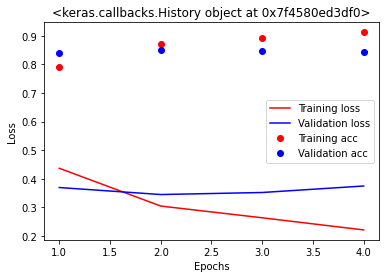

In [53]:
model_history(bilstm_model15_history)

In [39]:
bilstm15_results = bilstm_model.evaluate(test15,test_label15, verbose=2)

1397/1397 - 6s - loss: 0.3444 - accuracy: 0.8512


## 8-2. vocab 30000개 모델 훈련 및 평가

In [40]:
vocab_size = len(uni30_word_index)  # 어휘 사전의 크기입니다
word_vector_dim = 64  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 
batch_size = 256
dropout_rate = 0.2

In [41]:
bilstm_model30 = BiLSTModel(vocab_size, word_vector_dim, dropout_rate)

In [42]:
# 모델 빌드
bilstm_model30.build(input_shape=(None, 80))
                   
# 모델 컴파일
bilstm_model30.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
                   
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
                   
epochs=10

bilstm_model30_history = bilstm_model30.fit(x_train30,
                                        y_train30,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        validation_data=(x_val30, y_val30),
                                        verbose=1,
                                        callbacks=[es])

Epoch 1/10
416/416 [==============================] - 11s 20ms/step - loss: 0.4510 - accuracy: 0.7812 - val_loss: 0.3648 - val_accuracy: 0.8399
Epoch 2/10
416/416 [==============================] - 8s 19ms/step - loss: 0.2831 - accuracy: 0.8852 - val_loss: 0.3533 - val_accuracy: 0.8497
Epoch 3/10
416/416 [==============================] - 8s 19ms/step - loss: 0.2256 - accuracy: 0.9116 - val_loss: 0.3740 - val_accuracy: 0.8462
Epoch 4/10
416/416 [==============================] - 8s 19ms/step - loss: 0.1744 - accuracy: 0.9342 - val_loss: 0.4122 - val_accuracy: 0.8420
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


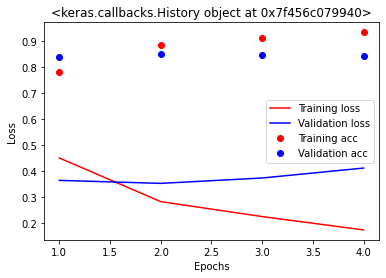

In [54]:
model_history(bilstm_model30_history)

In [45]:
bilstm30_results = bilstm_model30.evaluate(test30,test_label30, verbose=2)

1397/1397 - 6s - loss: 0.3547 - accuracy: 0.8497


# 9. 한국어 토크나이저 적용해보기
- konlpy중에서도 mecab과 okt를 사용하여 모델을 평가해보도록 하겠습니다.
## 9-1. Mecab 적용해보기

In [78]:
def konlpy_tokenizer(konlpy, train, test):
    
    ko_token = konlpy()
    
    train_list = []
    test_list = []
    
    for sentence in tqdm(train['document']):
        train_list.append(ko_token.morphs(sentence))
        
    for sentence in tqdm(test['document']):
        test_list.append(ko_token.morphs(sentence))

    tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True, num_words=30000,filters='')
    tokenizer.fit_on_texts(train_list)

    train_data = tokenizer.texts_to_sequences(train_list)
    test_data = tokenizer.texts_to_sequences(test_list)
    
    train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data, padding='pre')
    test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data, padding='pre')

    train_label = np.array(train['label'])
    test_label = np.array(test['label'])

    return train_data, train_label, test_data, test_label, tokenizer

In [79]:
train_data, train_label, test_data, test_label, mecab_tokenizer = konlpy_tokenizer(Mecab, train11, test11)

100%|██████████| 44692/44692 [00:02<00:00, 15283.88it/s]


In [80]:
mecab_x_train, mecab_x_val, mecab_y_train, mecab_y_val = train_test_split(train_data,
                                                                          train_label,
                                                                          test_size=0.2,
                                                                          shuffle=True,
                                                                          stratify=train_label,
                                                                          random_state=1234)

In [81]:
vocab_size = len(mecab_tokenizer.word_index)  # 어휘 사전의 크기입니다
word_vector_dim = 64  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 
batch_size = 256
dropout_rate = 0.2

In [82]:
mecab_model = BiLSTModel(vocab_size, word_vector_dim, dropout_rate)

In [83]:
# 모델 빌드
mecab_model.build(input_shape=(None, 80))
                   
# 모델 컴파일
mecab_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
                   
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
                   
epochs=10

mecab_model_history = mecab_model.fit(mecab_x_train,
                                        mecab_y_train,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        validation_data=(mecab_x_val, mecab_y_val),
                                        verbose=1,
                                        callbacks=[es])

Epoch 1/10
416/416 [==============================] - 9s 16ms/step - loss: 0.4087 - accuracy: 0.8110 - val_loss: 0.3516 - val_accuracy: 0.8468
Epoch 2/10
416/416 [==============================] - 6s 14ms/step - loss: 0.3030 - accuracy: 0.8748 - val_loss: 0.3469 - val_accuracy: 0.8469
Epoch 3/10
416/416 [==============================] - 6s 14ms/step - loss: 0.2525 - accuracy: 0.8990 - val_loss: 0.3540 - val_accuracy: 0.8523
Epoch 4/10
416/416 [==============================] - 6s 14ms/step - loss: 0.2113 - accuracy: 0.9185 - val_loss: 0.3559 - val_accuracy: 0.8506
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


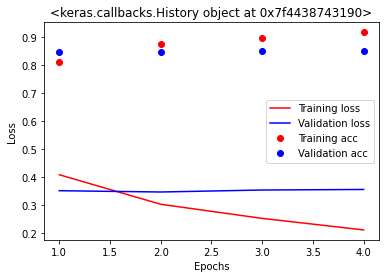

In [84]:
model_history(mecab_model_history)

In [85]:
mecab_model_results = mecab_model.evaluate(test_data,test_label, verbose=2)

1397/1397 - 6s - loss: 0.3466 - accuracy: 0.8484


## 9-2. Okt 적용해보기

In [86]:
train_data, train_label, test_data, test_label, okt_tokenizer = konlpy_tokenizer(Okt, train11, test11)

100%|██████████| 44692/44692 [01:07<00:00, 660.90it/s]


In [87]:
okt_x_train, okt_x_val, okt_y_train, okt_y_val = train_test_split(train_data,
                                                                  train_label,
                                                                  test_size=0.2,
                                                                  shuffle=True,
                                                                  stratify=train_label,
                                                                  random_state=1234)

In [88]:
vocab_size = len(okt_tokenizer.word_index)  # 어휘 사전의 크기입니다
word_vector_dim = 64  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 
batch_size = 256
dropout_rate = 0.2

In [89]:
okt_model = BiLSTModel(vocab_size, word_vector_dim, dropout_rate)

In [90]:
# 모델 빌드
okt_model.build(input_shape=(None, 80))
                   
# 모델 컴파일
okt_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
                   
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
                   
epochs=10

okt_model_history = okt_model.fit(okt_x_train,
                                    okt_y_train,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    validation_data=(okt_x_val, okt_y_val),
                                    verbose=1,
                                    callbacks=[es])

Epoch 1/10
416/416 [==============================] - 11s 16ms/step - loss: 0.4139 - accuracy: 0.8035 - val_loss: 0.3483 - val_accuracy: 0.8456
Epoch 2/10
416/416 [==============================] - 6s 14ms/step - loss: 0.2901 - accuracy: 0.8793 - val_loss: 0.3448 - val_accuracy: 0.8496
Epoch 3/10
416/416 [==============================] - 6s 14ms/step - loss: 0.2404 - accuracy: 0.9026 - val_loss: 0.3738 - val_accuracy: 0.8468
Epoch 4/10
416/416 [==============================] - 6s 14ms/step - loss: 0.1956 - accuracy: 0.9224 - val_loss: 0.3997 - val_accuracy: 0.8432
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


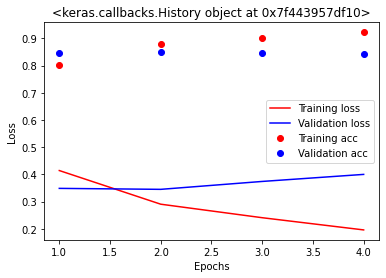

In [91]:
model_history(okt_model_history)

In [92]:
okt_model_results = okt_model.evaluate(test_data,test_label, verbose=2)

1397/1397 - 6s - loss: 0.3431 - accuracy: 0.8521


# 10. Tokenizer별 성능비교

       Model  Test Loss  Test Accuracy
0  unigram15   0.344411       0.851159
1  unigram30   0.354696       0.849727
2      Mecab   0.346623       0.848429
3        Okt   0.343087       0.852121


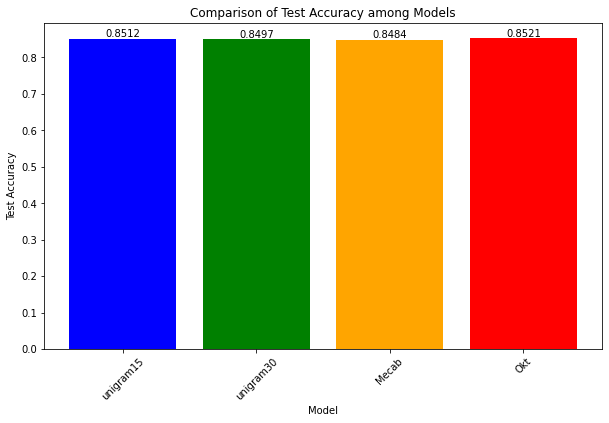

In [99]:
data = {'Model': ['unigram15', 'unigram30', 'Mecab', 'Okt'],
        'Test Loss': [bilstm15_results[0], bilstm30_results[0], mecab_model_results[0], okt_model_results[0]],
        'Test Accuracy': [bilstm15_results[1], bilstm30_results[1], mecab_model_results[1], okt_model_results[1]]}

df = pd.DataFrame(data)
print(df)

# 바차트 그리기

colors = ['blue', 'green', 'orange', 'red']

plt.figure(figsize=(10, 6))
bars = plt.bar(df['Model'], df['Test Accuracy'], color=colors)
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Test Accuracy among Models')
plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), ha='center', va='bottom')

plt.show()

- 4가지 tokenizer를 비교해보았습니다.
- 대체적으로 비슷한 성능을 보였지만, 가장 좋은 성능은 Okt_tokenizer입니다.
- Mecab은 4가지 중 가장 낮은 test 성능을 보였습니다.

# 전체회고
- 생각보다 쉬우면서 어려웠습니다.
- 어려웠던 것은 어떻게 하면 함수로 편하게 짤 수 있을까를 많이 고민했던것 같습니다.
- 범용적으로 쓰일수 있도록 짜기 위해 고민을 많이 하고 여러번 고치고 짰던것 같습니다.
- 또한 이전에 공부했던 내용을 녹여내고자 많은 투자를 하였습니다.
- sentenceppiece-bpe는 아무리 기다려도 vocab과 model이 만들어지지 않아 시도하지 못했습니다.
- 하지만 훈련시키는 방법은 알았기에 주석처리 해두었습니다.
- sentenceppiece-unigram의 성능이 더 좋을 것이라고 생각했는데, Okt의 성능도 나름 좋은 성능을 보이는것 같습니다.
- 모델을 짜는 다양한 방법들을 공부하면 더 좋을 것 같습니다.
- 앞으로는 해당 과제를 pytorch로 구현하는 연습도 하면 도움이 될 것 같다고 생각합니다.

# 참고자료
- https://paul-hyun.github.io/vocab-with-sentencepiece/
- https://wikidocs.net/86657
- https://wikidocs.net/94748
- https://github.com/google/sentencepiece
- 이전 수행 노드들